### Business Objective

* Identifying customers’ interest in products.

### Business Constraint(s)

* Maximize sales.
* Optimize product placement.
* Optimize promotional strategies.
* Maximize prediction of customer behavior.

### Import Dependecies

In [1]:
# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

from dython.nominal import identify_nominal_columns, associations

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder

# to compute distances
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage


# to perform k-means clustering, Agglomerative clustering and compute silhouette scores
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from mlxtend.frequent_patterns import apriori, association_rules

import networkx as nx  # Python package for the creation and study of complex networks

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

**Read the dataset**

In [2]:
## Read the dataset
data = pd.read_csv("Bakery.csv")

## making a copy of the dataset
df = data.copy()

<IPython.core.display.Javascript object>

**View the first and last 5 rows of the dataset.**

In [3]:
## Top 5 rows
df.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend


<IPython.core.display.Javascript object>

In [4]:
## Last 5 rows
df.tail()

,TransactionNo,Items,DateTime,Daypart,DayType
20502,9682,Coffee,2017-09-04 14:32:58,Afternoon,Weekend
20503,9682,Tea,2017-09-04 14:32:58,Afternoon,Weekend
20504,9683,Coffee,2017-09-04 14:57:06,Afternoon,Weekend
20505,9683,Pastry,2017-09-04 14:57:06,Afternoon,Weekend
20506,9684,Smoothies,2017-09-04 15:04:24,Afternoon,Weekend


<IPython.core.display.Javascript object>

**Observations:**

* TransactionNo column can be dropped as it contains unique values and doesn't add any importance to the EDA.
* DateTime column can be dropped due to the current analysis focusing on the association rule of the products on the granular level i.e. purchases on daily basis (whether on weekdays or weekends) and during the day (whether on morning, afternoon, evening or night).

**Data Information**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionNo  20507 non-null  int64 
 1   Items          20507 non-null  object
 2   DateTime       20507 non-null  object
 3   Daypart        20507 non-null  object
 4   DayType        20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


<IPython.core.display.Javascript object>

**Observations:**

* The dataset contains 20,507 rows and 5 columns
* Except the Transaction column (int), all the columns are object(String).
* Since the whole datasets has 20504 rows and every column has 20504 record. Then, there is no missing values within the dataset.

**Check of missing values**

In [6]:
df.isnull().sum()

TransactionNo    0
Items            0
DateTime         0
Daypart          0
DayType          0
dtype: int64

<IPython.core.display.Javascript object>

**Observatins:**

* There is no missing value within the dataset/

In [7]:
## Drop DateTime, transaction columns

df.drop(["TransactionNo", "DateTime"], axis=1, inplace=True)
df.head()

,Items,Daypart,DayType
0,Bread,Morning,Weekend
1,Scandinavian,Morning,Weekend
2,Scandinavian,Morning,Weekend
3,Hot chocolate,Morning,Weekend
4,Jam,Morning,Weekend


<IPython.core.display.Javascript object>

**Statistical Summary**

In [8]:
df.describe().T

,count,unique,top,freq
Items,20507,94,Coffee,5471
Daypart,20507,4,Afternoon,11569
DayType,20507,2,Weekday,12807


<IPython.core.display.Javascript object>

**Observations**

* The top most Item in transactions is Coffee.
* The high frequency of transactions are in the Afternoon.
* The most of the transactions are within the weekdays.

**Check for value counts**

In [9]:
## Check for value counts

# printing the number of occurrences of each unique value in each column
for i in df.columns:
    print(df[i].value_counts())
    print("-" * 50)
    print("\n")

Coffee            5471
Bread             3325
Tea               1435
Cake              1025
Pastry             856
                  ... 
Bacon                1
Gift voucher         1
Olum & polenta       1
Raw bars             1
Polenta              1
Name: Items, Length: 94, dtype: int64
--------------------------------------------------


Afternoon    11569
Morning       8404
Evening        520
Night           14
Name: Daypart, dtype: int64
--------------------------------------------------


Weekday    12807
Weekend     7700
Name: DayType, dtype: int64
--------------------------------------------------




<IPython.core.display.Javascript object>

**Observations**
* The observations from the statistical summary above are also applicable here.

### EDA



**Univariate analysis**

In [10]:
# labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

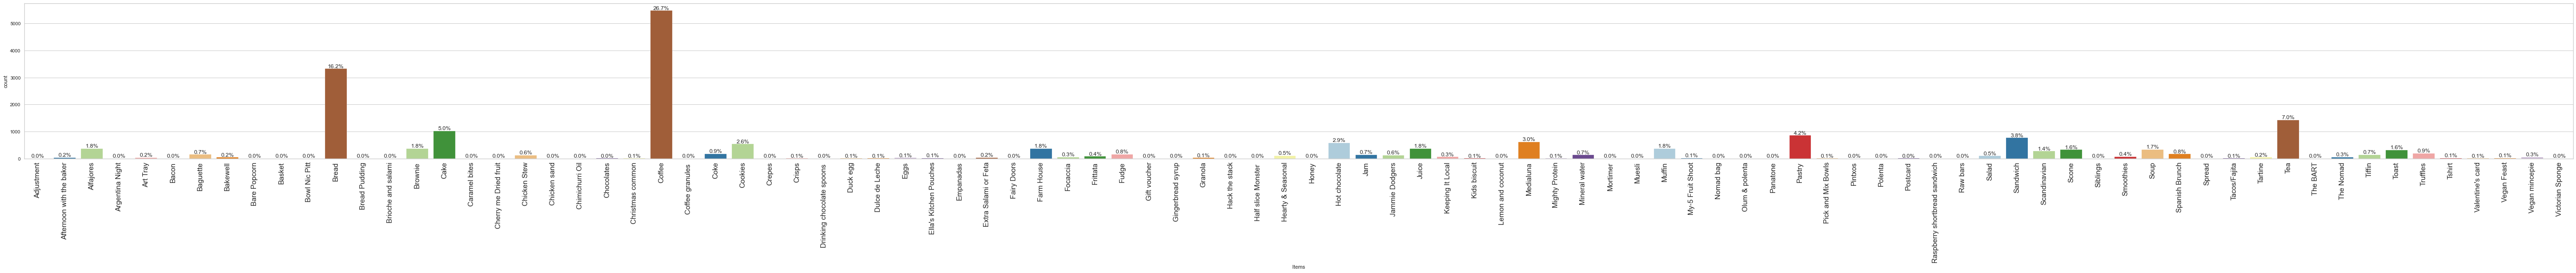

**************************************************



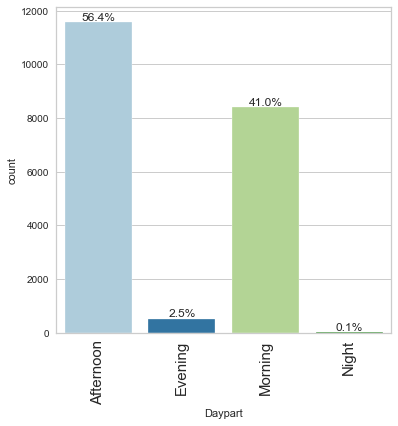

**************************************************



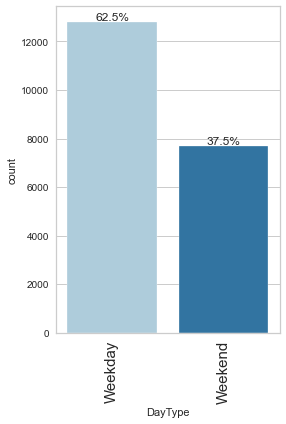

**************************************************



<IPython.core.display.Javascript object>

In [11]:
## Labeled barplot for the categorical features

for i in df.columns:
    labeled_barplot(df, i, perc=True)
    print("*" * 50)
    print("")

**Observations**

* Items:
   - The top 3 items as folllow:
        * 26.7% of the items is Coffee. 
        * 16.2% of the items is Bread.  
        * 7.0% of the items is Tea.


* Daypart
  * 56.4% of the transactions are the highest and happened within the Afternoon.
  * 41.0% of the transaction are ranked as a second and happened within the Morning.
  * 0.1% of transactions are the lowest and happened within the Night.


* DayType
  * 62.5% of the transactions are happened within the Weekday.
  * 37.5% of the transactions are happened within the Weekend.

**Comparision of Items with Daypart to understand the relation**

In [12]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

<IPython.core.display.Javascript object>

In [ ]:
stacked_barplot(df, "Items", "Daypart")

**Observations**

* The most busy durations for buying items are the Afternoon, and the morning.
* The top 3 items bought at the Afternoon, Evening, and Morning are Hot chocolate, Cookies, and then Juice.
* The top 3 items bought at the Night are Vegan Feast, Hot chocolate, and Valentine's card.
* The lowest items bought at the Afternoon are Valentine's card, Vegan Feast, and Honey.
* The lowest items bought at the Evening are Valentine's card, and Vegan Feast.
* The lowest items bought at the Morning are Drinking chocolate spoons, and Vegan Feast.
* The lowest items bought at the Night are Juice, Hot chocolate, and Valentine's card.

**Comparision of Items with DayType to understand the relation**

DayType         Weekday  Weekend    All
Items                                  
All               12807     7700  20507
Coffee             3543     1928   5471
Bread              2092     1233   3325
Tea                 976      459   1435
Cake                612      413   1025
...                 ...      ...    ...
Polenta               1        0      1
Hack the stack        2        0      2
Olum & polenta        1        0      1
Siblings              2        0      2
Adjustment            1        0      1

[95 rows x 3 columns]
------------------------------------------------------------------------------------------------------------------------


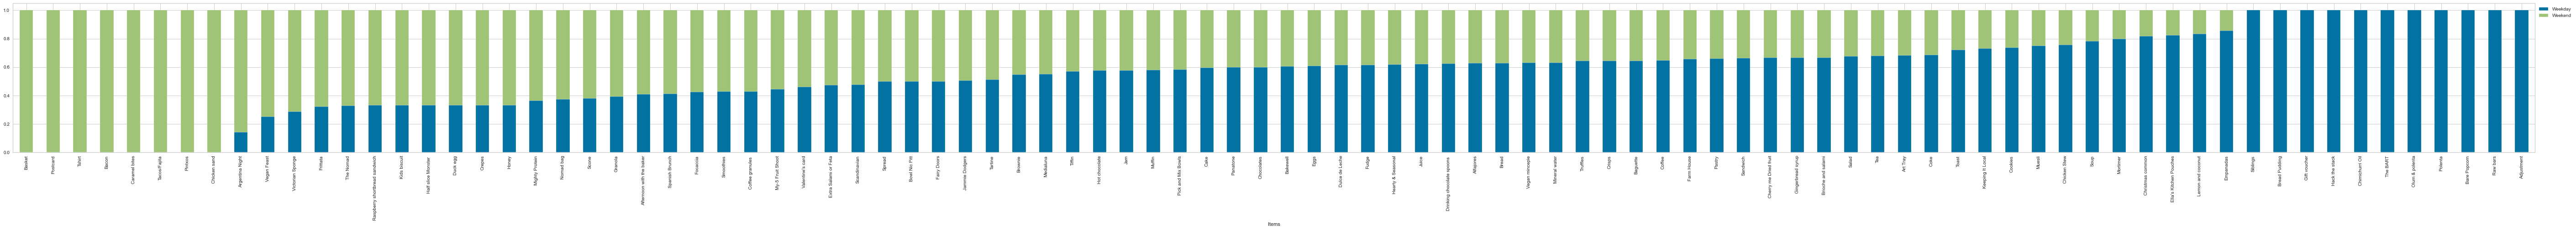

<IPython.core.display.Javascript object>

In [13]:
stacked_barplot(df, "Items", "DayType")

**Observations**

* The frequency of buying items during the Weekday is higher than the Weekend.
* The top 3 items bought during the Weekday are Coffee, Bread, and Tea.
* The top 3 items bought during the Weekend are Coffee, Bread, and Tea.
* The lowest items bought during the Weekday are Polenta, Olum & polenta, and Adjustment.

**Correlation Matrix**

  * Since the features are categorical type, We are going to use Cramer’s V or Theil’s U for categorical-categorical cases.
  * That type of analysis is available in a python package called "dython".
  * The following heat map of the correlations between the categorical-categorical is getting by the usage of the "dython" package.

In [14]:
## Dytohn package is also powerful in identifying the categorical features

categorical_features = identify_nominal_columns(df)
print("The categorical features are :", categorical_features)

The categorical features are : ['Items', 'Daypart', 'DayType']


<IPython.core.display.Javascript object>

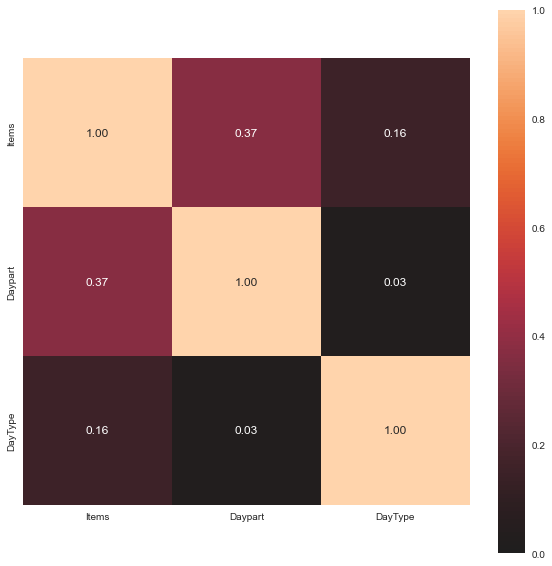

<IPython.core.display.Javascript object>

In [15]:
## Heatmap showing the correlations between the features
categorical_correlation = associations(df, figsize=(10, 10))

**Observations**
 
  * The correlation between the items and Daypart is 0.37 which is weak correlation.
  * The correlation between the items and Daytype is 0.16 which is weak correlation.
  * The correlation between the Daypart and Daytype is 0.03 which is weak correlation.

### Summary of EDA


**Data Description:**

 * Data has 20507 rows and 5 columns.
 * Except TransactionNo column, the datatype of other columns are object(String).
 
**Data Cleaning:**

 * Data does not have any missing values.
 * It has duplicated values and that is okay since we are going to conduction market basket analysis.
 * The TransactionNo and DateTime columns were droped since they aren't added any value to the analysis.
 

**Statistical Summary:**

 * The top most Item in transactions is Coffee.
 * The high frequency of transactions done in the Afternoon.
 * The most of the transactions done within the weekdays.


**Univariate Analysis:**

* Items:
  * The top 3 items as folllow:
     * 26.7% of the items is Coffee.
     * 16.2% of the items is Bread.
     * 7.0% of the items is Tea.

* Daypart
  * 56.4% of the transactions done within the Afternoon.
  * 41.0% of the transaction done within the Morning.
  * 0.1% of transaction done within the Night which is the lower.

* DayType
  * 62.5% of the transactions done within the Weekday.
  * 37.5% of the transactions done within the Weekend.
  
  
**Comparision of Items with Daypart:**

* The most busy durations for buying items are the Afternoon, and the morning.
* The top 3 items bought at the Afternoon, Evening, and Morning are Hot chocolate, Cookies, and then Juice.
* The top 3 items bought at the Night are Vegan Feast, Hot chocolate, and Valentine's card.
* The lowest items bought at the Afternoon are Valentine's card, Vegan Feast, and Honey.
* The lowest items bought at the Evening are Valentine's card, and Vegan Feast.
* The lowest items bought at the Morning are Drinking chocolate spoons, and Vegan Feast.
* The lowest items bought at the Night are Juice, Hot chocolate, and Valentine's card.

**Comparision of Items with DayType:**

* The frequency of buying items during the Weekday is higher than the Weekend.
* The top 3 items bought during the Weekday are Coffee, Bread, and Tea.
* The top 3 items bought during the Weekend are Coffee, Bread, and Tea.
* The lowest items bought during the Weekday are Polenta, Olum & polenta, and Adjustment.


**Correlation Matrix:**

* The correlation between the items and Daypart is 0.37 which is weak correlation.
* The correlation between the items and Daytype is 0.16 which is weak correlation.
* The correlation between the Daypart and Daytype is 0.03 which is weak correlation.

### Data Preprocessing

**Encoding**

In [16]:
## Label Encoder

df_enc = df.copy()  # creating a copy from origina; dataframe

# Instantiate Label Encoder
label_enc = LabelEncoder()

# Fit & Transform data
df_enc["Items"] = label_enc.fit_transform(df_enc["Items"])


df_enc.head()

,Items,Daypart,DayType
0,11,Morning,Weekend
1,74,Morning,Weekend
2,74,Morning,Weekend
3,48,Morning,Weekend
4,49,Morning,Weekend


<IPython.core.display.Javascript object>

In [17]:
## Classes of label encoder in Items
for ix, i in enumerate(label_enc.classes_):
    print(ix, i)

0 Adjustment
1 Afternoon with the baker
2 Alfajores
3 Argentina Night
4 Art Tray
5 Bacon
6 Baguette
7 Bakewell
8 Bare Popcorn
9 Basket
10 Bowl Nic Pitt
11 Bread
12 Bread Pudding
13 Brioche and salami
14 Brownie
15 Cake
16 Caramel bites
17 Cherry me Dried fruit
18 Chicken Stew
19 Chicken sand
20 Chimichurri Oil
21 Chocolates
22 Christmas common
23 Coffee
24 Coffee granules 
25 Coke
26 Cookies
27 Crepes
28 Crisps
29 Drinking chocolate spoons 
30 Duck egg
31 Dulce de Leche
32 Eggs
33 Ella's Kitchen Pouches
34 Empanadas
35 Extra Salami or Feta
36 Fairy Doors
37 Farm House
38 Focaccia
39 Frittata
40 Fudge
41 Gift voucher
42 Gingerbread syrup
43 Granola
44 Hack the stack
45 Half slice Monster 
46 Hearty & Seasonal
47 Honey
48 Hot chocolate
49 Jam
50 Jammie Dodgers
51 Juice
52 Keeping It Local
53 Kids biscuit
54 Lemon and coconut
55 Medialuna
56 Mighty Protein
57 Mineral water
58 Mortimer
59 Muesli
60 Muffin
61 My-5 Fruit Shoot
62 Nomad bag
63 Olum & polenta
64 Panatone
65 Pastry
66 Pick and 

<IPython.core.display.Javascript object>

In [18]:
# Instantiate Label Encoder
label_enc = LabelEncoder()

# Fit & Transform data
df_enc["Daypart"] = label_enc.fit_transform(df_enc["Daypart"])

df_enc.head()

,Items,Daypart,DayType
0,11,2,Weekend
1,74,2,Weekend
2,74,2,Weekend
3,48,2,Weekend
4,49,2,Weekend


<IPython.core.display.Javascript object>

In [19]:
## Classes of label encoder in Daypart
for ix, i in enumerate(label_enc.classes_):
    print(ix, i)

0 Afternoon
1 Evening
2 Morning
3 Night


<IPython.core.display.Javascript object>

In [20]:
# Instantiate Label Encoder
label_enc = LabelEncoder()

# Fit & Transform data
df_enc["DayType"] = label_enc.fit_transform(df_enc["DayType"])

df_enc.head()

,Items,Daypart,DayType
0,11,2,1
1,74,2,1
2,74,2,1
3,48,2,1
4,49,2,1


<IPython.core.display.Javascript object>

In [21]:
## Classes of label encoder in Daypart
for ix, i in enumerate(label_enc.classes_):
    print(ix, i)

0 Weekday
1 Weekend


<IPython.core.display.Javascript object>

* The encoded values for Daypart column as follow:
    * **2 = Morning**
    * **0 = Afternoon**
    * **1 = Evening**
    * **3 = Night**
    
* The encoded values for DayType column as follow:
    * **0 = Weekday**
    * **1 = Weekend**

**Data Normalization**

In [22]:
## Features scaling using MinMaxScaler
mc = MinMaxScaler()
df1_norm = pd.DataFrame(
    mc.fit_transform(df_enc),
    columns=df_enc.columns,
)

df2_norm = df1_norm.copy()
df1_norm.head()

,Items,Daypart,DayType
0,0.118280,0.666667,1.0
1,0.795699,0.666667,1.0
2,0.795699,0.666667,1.0
3,0.516129,0.666667,1.0
4,0.526882,0.666667,1.0


<IPython.core.display.Javascript object>

### Clustering Analysis

**Kmeans**

Number of Clusters: 1 	 Average Distortion: 0.6401777144921785
Number of Clusters: 2 	 Average Distortion: 0.42336027870986126
Number of Clusters: 3 	 Average Distortion: 0.3222929757188163
Number of Clusters: 4 	 Average Distortion: 0.2602853911734824
Number of Clusters: 5 	 Average Distortion: 0.19657500490967245
Number of Clusters: 6 	 Average Distortion: 0.1599674583329309
Number of Clusters: 7 	 Average Distortion: 0.12292429402601734
Number of Clusters: 8 	 Average Distortion: 0.09932555484749583
Number of Clusters: 9 	 Average Distortion: 0.08967173037806724


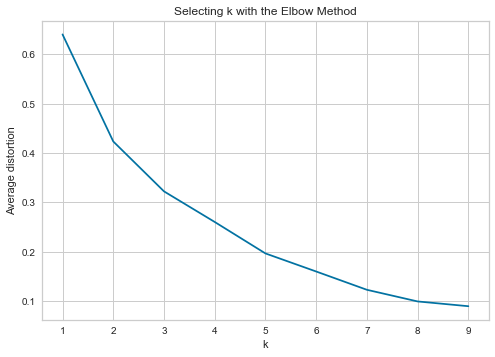

<IPython.core.display.Javascript object>

In [23]:
## Choose Euclidean distance

clusters = range(1, 10)  # Define a range for clusters
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df1_norm)
    prediction = model.predict(df1_norm)
    distortion = (
        sum(np.min(cdist(df1_norm, model.cluster_centers_, metric="euclidean"), axis=1))
        / df1_norm.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\t Average Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

**Insights**

* Appropriate vlaue for k seems to be 5.
* To check which one is the right, we will Silhouette score for validation.

**Observation**

* The rule for clustering is to choose sutiable number of clusters.
* From the silhouette score graph above, the k=4 is giving high score irrespect to k=9.
* From there, the suitable number of clusters is **k=5**.

In [25]:
## Let's take k=4
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df1_norm)

KMeans(n_clusters=5, random_state=42)

<IPython.core.display.Javascript object>

In [26]:
# Adding kmeans cluster labels to the encoded dataframe and the original dataframe
df_old = df.copy()  ## copy from the original dataframe
df_encK = df_enc.copy()
df_old["K_means_segments"] = kmeans.labels_
df_encK["K_means_segments"] = kmeans.labels_

df_old.head()

,Items,Daypart,DayType,K_means_segments
0,Bread,Morning,Weekend,0
1,Scandinavian,Morning,Weekend,0
2,Scandinavian,Morning,Weekend,0
3,Hot chocolate,Morning,Weekend,0
4,Jam,Morning,Weekend,0


<IPython.core.display.Javascript object>

In [27]:
df_encK.head()

,Items,Daypart,DayType,K_means_segments
0,11,2,1,0
1,74,2,1,0
2,74,2,1,0
3,48,2,1,0
4,49,2,1,0


<IPython.core.display.Javascript object>

**Kmeans Clustering Profiling**

In [28]:
cluster_profile = df_encK.groupby(["K_means_segments"]).agg(pd.Series.mode)
cluster_profile["Count_in_each_segment"] = (
    df_encK.groupby(["K_means_segments"])["Daypart"].count().values
)

<IPython.core.display.Javascript object>

In [29]:
# Display Cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Items,Daypart,DayType,Count_in_each_segment
K_means_segments,,,,
0,23,2,1,3310
1,23,0,0,4573
2,23,2,0,5240
3,23,0,1,4390
4,83,0,0,2994


<IPython.core.display.Javascript object>

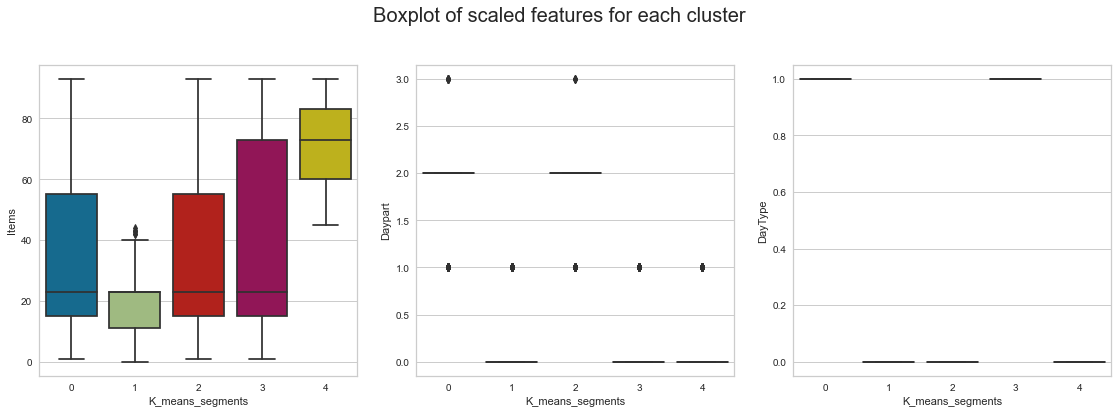

<IPython.core.display.Javascript object>

In [30]:
cols = [
    "Items",
    "Daypart",
    "DayType",
]

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle("Boxplot of scaled features for each cluster", fontsize=20)
counter = 0
for i in range(3):
    sns.boxplot(
        ax=axes[i],
        y=df_encK[cols[counter]],
        x=df_encK["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Observations**

* **Cluster 0:**

    - In this cluster **the top purchased item is Coffee (encoded as 23), bought in the morning during the weekend.**
    
    
* **Cluster 1:**

    - In this cluster **the top purchased item is Coffee (encoded as 23), bought in the afternoon during the weekday.**
    
    
* **Cluster 2:**

    - In this cluster **the top purchased item is Coffee (encoded as 23), bought in the morning during the weekday.**
 
 
* **Cluster 3:**

    - In this cluster the **top purchased item is Coffee (encoded as 23), bought in the afternoon during the weekend.**
    
    
 * **Cluster 4:**

    - In this cluster the **top purchased item is Tea (encoded as 83), bought in the afternoon during the weekday.**

**Based on Kmeans Clustering:**

* Cluster 0 represents the low cluster in the buying frequency for Coffee in the morning during the Weekend.


* Cluster 1 represents the higher cluster in the buying frequency for Coffee in the afternoon during the Weekday.


* Cluster 2 represents the highest cluster in the buying frequency for Coffee in the morning during the Weekday.


* Cluster 3 represents the high cluster in the buying frequency for Coffee in the afternoon during the Weekend.


* Cluster 4 represents the lower cluster in the buying frequency for Tea in the afternoon during the Weekday.

### Clustering Analysis

**Hierarchical Clustering**

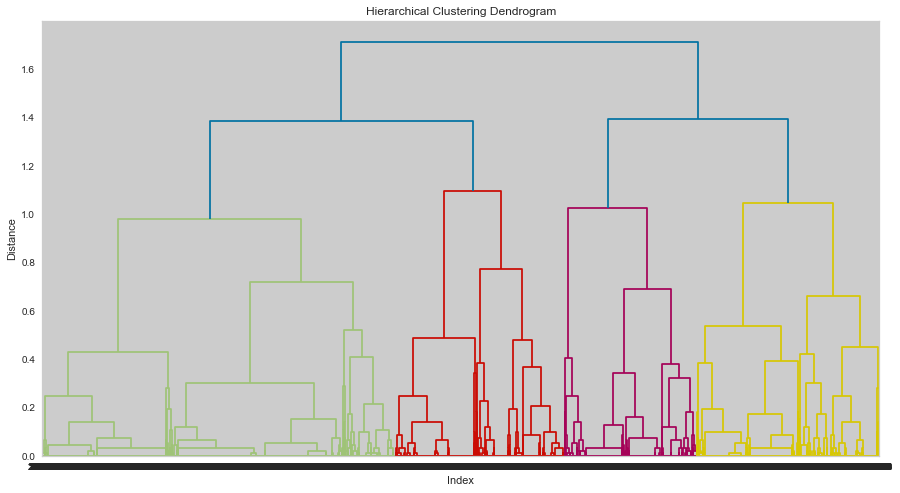

<IPython.core.display.Javascript object>

In [31]:
# Creating dendrogram 

z = linkage(df2_norm, method = "complete", metric = "euclidean")

# Dendrogram

plt.figure(figsize=(15, 8));plt.title('Hierarchical Clustering Dendrogram');plt.xlabel('Index');plt.ylabel('Distance')
sch.dendrogram(z, 
    leaf_rotation = 0,  # rotates the x axis labels
    leaf_font_size = 10 # font size for the x axis labels
)
plt.show()


**Observations**

* The number of clusters from the dendogram is to be k=4.

In [32]:
# Now applying AgglomerativeClustering choosing k=4 as clusters from the above dendrogram

h_complete = AgglomerativeClustering(
    n_clusters=4, linkage="complete", affinity="euclidean"
).fit(df2_norm)
h_complete.labels_

array([2, 2, 2, ..., 1, 1, 1], dtype=int64)

<IPython.core.display.Javascript object>

* The labels are 0, 1, 2, and 3.

In [33]:
cluster_labels = pd.Series(h_complete.labels_)

df_oldH = df.copy()  ## copy from the original dataframe
df_encH = df_enc.copy()

df_oldH[
    "clust"
] = cluster_labels  # creating a new column and assigning it to new column


df_encH[
    "clust"
] = cluster_labels  # creating a new column and assigning it to new column

df_oldH.head()

,Items,Daypart,DayType,clust
0,Bread,Morning,Weekend,2
1,Scandinavian,Morning,Weekend,2
2,Scandinavian,Morning,Weekend,2
3,Hot chocolate,Morning,Weekend,2
4,Jam,Morning,Weekend,2


<IPython.core.display.Javascript object>

In [34]:
np.unique(h_complete.labels_)

array([0, 1, 2, 3], dtype=int64)

<IPython.core.display.Javascript object>

**Hierarchical Clustering Profiling**

In [35]:
cluster_profile_1 = df_encH.groupby(["clust"]).agg(pd.Series.mode)
cluster_profile_1["Count_in_each_segment"] = (
    df_encH.groupby(["clust"])["Daypart"].count().values
)

<IPython.core.display.Javascript object>

In [36]:
# Display Cluster profiles
cluster_profile_1.style.highlight_max(color="lightblue", axis=0)

,Items,Daypart,DayType,Count_in_each_segment
clust,,,,
0,83,2,0,4134
1,23,0,1,4460
2,23,2,1,3240
3,23,0,0,8673


<IPython.core.display.Javascript object>

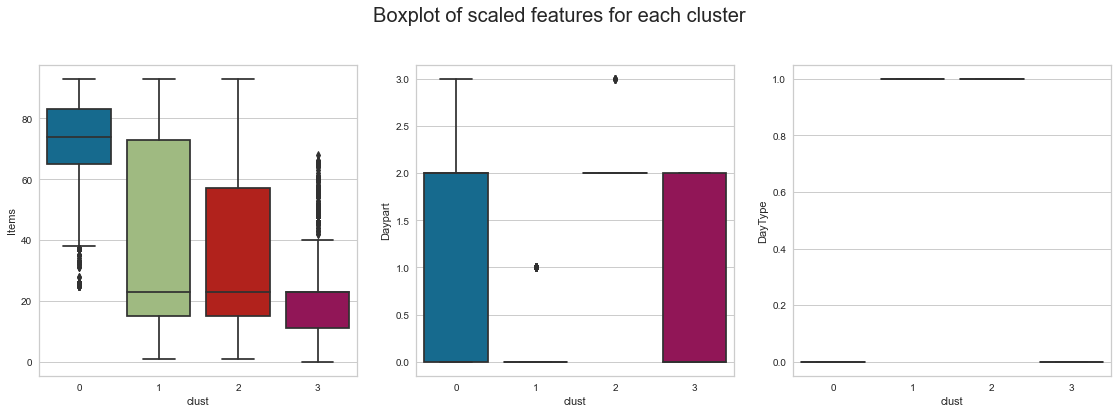

<IPython.core.display.Javascript object>

In [37]:
## Plot the clusters

cols = [
    "Items",
    "Daypart",
    "DayType",
]

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle("Boxplot of scaled features for each cluster", fontsize=20)
counter = 0
for i in range(3):
    sns.boxplot(
        ax=axes[i],
        y=df_encH[cols[counter]],
        x=df_encH["clust"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Observations**

* **Cluster 0:**

    - In this cluster **the top purchased item is Tea (encoded as 83), bought in the morning during the weekday.**
    
    
* **Cluster 1:**

    - In this cluster **the top purchased item is Coffee (encoded as 23), bought in the afternoon during the weekend.** 
    
    
* **Cluster 2:**

    - In this cluster **the top purchased item is Coffee (encoded as 23), bought in the morning during the weekend.** 
    
    
* **Cluster 3:**

    - In this cluster the **top purchased item is Coffee (encoded as 23), bought in the afternoon during the weekday.**    

**Based on Hierarchical  Clustering:**

* Cluster 0 represents the high cluster in the buying frequency for Tea in the morning during the Weekday.

* Cluster 1 represents the higher cluster in the buying frequency for Coffee in the afternoon during the Weekend.

* Cluster 2 represents the low cluster in the buying frequency for Coffee in the morning during the Weekend.

* Cluster 3 represents the highest cluster in the buying frequency for Coffee in the afternoon during the Weekday. 

### Association Rules

**Data Preparation**

In [38]:
## Dataset
df_rule = data.copy()

## We are going to analyze the items during the day part and day type

df_rule = df_rule[["TransactionNo", "Items"]].reset_index(drop=True)

df_rule.head()

,TransactionNo,Items
0,1,Bread
1,2,Scandinavian
2,2,Scandinavian
3,3,Hot chocolate
4,3,Jam


<IPython.core.display.Javascript object>

In [39]:
# Data Cleaning

df_rule["Items"] = df_rule["Items"].str.strip()  # removes spaces from beginning and end
df_rule["TransactionNo"] = df_rule["TransactionNo"].astype(
    "str"
)  # converting transaction number to be string

print("Data shape (rows, columns):", df_rule.shape)

Data shape (rows, columns): (20507, 2)


<IPython.core.display.Javascript object>

In [40]:
df_rule1 = df_rule.groupby("TransactionNo").agg(",".join).reset_index()
df_rule1.head()

,TransactionNo,Items
0,1,Bread
1,10,"Scandinavian,Medialuna"
2,100,Bread
3,1000,"Scandinavian,Chimichurri Oil"
4,1001,"Bread,Truffles"


<IPython.core.display.Javascript object>

* The items of Scandinavian, and Chimichurri Oil together have 1000 number of transactions.
* The items of Bread,Truffles together have 1001 number of transactions.

In [41]:
## Getting all the items in a list

items_list = [item.split(",") for item in df_rule1["Items"]]
items_list

[['Bread'],
 ['Scandinavian', 'Medialuna'],
 ['Bread'],
 ['Scandinavian', 'Chimichurri Oil'],
 ['Bread', 'Truffles'],
 ['Brownie', 'Focaccia'],
 ['Coffee', 'Bread'],
 ['Coffee', 'Tea', 'Art Tray', 'Cookies'],
 ['Coffee'],
 ['Bread'],
 ['Coffee', 'Alfajores', 'Alfajores', 'Coke'],
 ['Bread'],
 ['Bread'],
 ['Coffee', 'Pastry'],
 ['Bread', 'Pastry', 'Medialuna', 'Coffee'],
 ['Coffee'],
 ['Bread', 'Keeping It Local'],
 ['Bread'],
 ['Coffee', 'Scandinavian'],
 ['Bread', 'Farm House', 'Pastry', 'Medialuna'],
 ['Medialuna'],
 ['Coffee'],
 ['Bread', 'Farm House'],
 ['Bread'],
 ['Farm House'],
 ['Keeping It Local', 'Bread'],
 ['Bread', 'Medialuna'],
 ['Tea'],
 ['Coffee', 'Coffee', 'Pastry', 'Keeping It Local'],
 ['Coffee'],
 ['Tea'],
 ['Hot chocolate'],
 ['Tea', 'Sandwich'],
 ['Bread'],
 ['Medialuna', 'Muffin', 'Brownie'],
 ['Bread'],
 ['Coffee', 'Muffin'],
 ['Bread'],
 ['Coffee', 'Medialuna'],
 ['Coffee'],
 ['Coffee', 'Medialuna'],
 ['Coffee'],
 ['Coffee', 'Hot chocolate', 'Brownie', 'Bread'],

<IPython.core.display.Javascript object>

In [42]:
## Making all the items in a one list instead of list of lists

all_items_list = [i for item in items_list for i in item]
all_items_list

['Bread',
 'Scandinavian',
 'Medialuna',
 'Bread',
 'Scandinavian',
 'Chimichurri Oil',
 'Bread',
 'Truffles',
 'Brownie',
 'Focaccia',
 'Coffee',
 'Bread',
 'Coffee',
 'Tea',
 'Art Tray',
 'Cookies',
 'Coffee',
 'Bread',
 'Coffee',
 'Alfajores',
 'Alfajores',
 'Coke',
 'Bread',
 'Bread',
 'Coffee',
 'Pastry',
 'Bread',
 'Pastry',
 'Medialuna',
 'Coffee',
 'Coffee',
 'Bread',
 'Keeping It Local',
 'Bread',
 'Coffee',
 'Scandinavian',
 'Bread',
 'Farm House',
 'Pastry',
 'Medialuna',
 'Medialuna',
 'Coffee',
 'Bread',
 'Farm House',
 'Bread',
 'Farm House',
 'Keeping It Local',
 'Bread',
 'Bread',
 'Medialuna',
 'Tea',
 'Coffee',
 'Coffee',
 'Pastry',
 'Keeping It Local',
 'Coffee',
 'Tea',
 'Hot chocolate',
 'Tea',
 'Sandwich',
 'Bread',
 'Medialuna',
 'Muffin',
 'Brownie',
 'Bread',
 'Coffee',
 'Muffin',
 'Bread',
 'Coffee',
 'Medialuna',
 'Coffee',
 'Coffee',
 'Medialuna',
 'Coffee',
 'Coffee',
 'Hot chocolate',
 'Brownie',
 'Bread',
 'Bread',
 'Bread',
 'Bread',
 'Coffee',
 'Brownie

<IPython.core.display.Javascript object>

In [43]:
from collections import Counter  # To have the output in OrderedDict

item_frequencies = Counter(all_items_list)

# Sorting items_frequencies
item_frequencies = sorted(item_frequencies.items(), key=lambda x: x[1])
item_frequencies

[('Bacon', 1),
 ('Olum & polenta', 1),
 ('Polenta', 1),
 ('The BART', 1),
 ('Chicken sand', 1),
 ('Gift voucher', 1),
 ('Raw bars', 1),
 ('Adjustment', 1),
 ('Chimichurri Oil', 2),
 ('Fairy Doors', 2),
 ('Bowl Nic Pitt', 2),
 ('Spread', 2),
 ('Siblings', 2),
 ('Hack the stack', 2),
 ('Caramel bites', 3),
 ('Brioche and salami', 3),
 ('Raspberry shortbread sandwich', 3),
 ('Cherry me Dried fruit', 3),
 ('Bread Pudding', 4),
 ('Bare Popcorn', 5),
 ('Panatone', 5),
 ('Mortimer', 5),
 ('Basket', 6),
 ('Lemon and coconut', 6),
 ('Crepes', 6),
 ('Pintxos', 6),
 ('Honey', 6),
 ('Half slice Monster', 6),
 ('Victorian Sponge', 7),
 ('Coffee granules', 7),
 ('Empanadas', 7),
 ('Argentina Night', 7),
 ('Muesli', 8),
 ('Nomad bag', 8),
 ('Drinking chocolate spoons', 8),
 ('Gingerbread syrup', 9),
 ('Postcard', 10),
 ('Chocolates', 10),
 ('Mighty Protein', 11),
 ('Christmas common', 11),
 ('Tacos/Fajita', 11),
 ('Kids biscuit', 12),
 ('Pick and Mix Bowls', 12),
 ('Duck egg', 12),
 ('Dulce de Leche'

<IPython.core.display.Javascript object>

* The above result showing the item with its number of transaction frequency. 

In [45]:
# Storing frequencies and items in separate variables

frequencies = list(reversed([i[1] for i in item_frequencies]))
items = list(reversed([i[0] for i in item_frequencies]))

<IPython.core.display.Javascript object>

* The item_frequencies was splitted to frequencies and items lists.

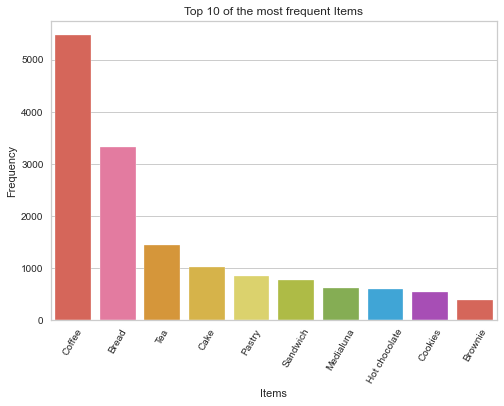

<IPython.core.display.Javascript object>

In [46]:
sns.color_palette("rocket", as_cmap=True)
sns.barplot(
    items[0:10],
    frequencies[0:10],
    palette=[
        "#ea5545",
        "#f46a9b",
        "#ef9b20",
        "#edbf33",
        "#ede15b",
        "#bdcf32",
        "#87bc45",
        "#27aeef",
        "#b33dc6",
    ],
)
plt.title("Top 10 of the most frequent Items")
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.xticks(
    list(
        range(0, 10),
    ),
    items[0:10],
    rotation=60,
)

**Observations**

* The highest purchased item goes to Coffee which has a frequency greater than 2500 number of times .
* The lowest purchased item goes to Brownie which have an approx. frequency of 250 number of times .

In [47]:
# Creating Data Frame for the transactions data

items_df = pd.DataFrame(pd.Series(items_list))
items_df.columns = ["Transaction"]
items_df

,Transaction
0,[Bread]
1,"[Scandinavian, Medialuna]"
2,[Bread]
3,"[Scandinavian, Chimichurri Oil]"
4,"[Bread, Truffles]"
...,...
9460,"[Coffee, Brownie]"
9461,"[Tea, Hot chocolate, Brownie, Truffles]"
9462,"[Coffee, Keeping It Local]"
9463,[Coffee]


<IPython.core.display.Javascript object>

* The created dataframe for the transacted items has 5089 rows and 1 column.

In [48]:
items_df.isna().sum()

Transaction    0
dtype: int64

<IPython.core.display.Javascript object>

* There are no records within the dataframe have null values.

In [49]:
# creating a dummy columns for the each item in each transactions ... Using column names as item name
new_df_items = items_df["Transaction"].str.join(sep="*").str.get_dummies(sep="*")
new_df_items

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

* The above dataframe showing all the items whether purchased one time or more (having value of 1) or not purchased (having value of zero).

In [50]:
## Check whether the maximum of all columns of X is greater than 1 or less than 0
for i in new_df_items.columns:
    if max(new_df_items[i]) > 1:
        print("There is value greater than 1")
    elif max(new_df_items[i]) < 0:
        print("There's a value less than 1")

<IPython.core.display.Javascript object>

* The dataset showed no values of greater than 1 or less than 0.

**Apriori Algorithm and Association Rule:**

* The common metrics to measure association are:

    * Support- It is the measure of frequency or abundance of an item in a dataset. It can be 'antecedent support', 'consequent support', and 'support'. 'antecedent support' contains proportion of transactions done for the antecedent while 'consequent support' involves those for consequent. 'Support' is computed for both antecedent and consequent in question.

    * Confidence-This gives the probability of consequent in a transaction given the presence of antecedent.

    * Lift- Given that antecedents and consequents are independent, how often do they come together/bought together.
    
    * Leverage- It is the difference between frequency of antecedent and consequent together in transactions to frequency of both in independent transactions. 
    * Conviction- A higher conviction score means that consequent is highly dependent on antecedent.

* Apriori algorithm is used to extract frequent itemsets that are further used for association rule analysis. In this algorithm, user defines a minimum support that is the minimum threshold that decides if an itemset is considered as 'frequent'.

In [51]:
## Applying Apriori Algorithim

frequent_itemsets = apriori(
    new_df_items, min_support=0.0075, max_len=4, use_colnames=True
)
frequent_itemsets

,support,itemsets
0,0.036344,(Alfajores)
1,0.016059,(Baguette)
2,0.327205,(Bread)
3,0.040042,(Brownie)
4,0.103856,(Cake)
...,...,...
70,0.008347,"(Tea, Scone)"
71,0.009086,"(Tea, Soup)"
72,0.010037,"(Coffee, Bread, Cake)"
73,0.011199,"(Coffee, Pastry, Bread)"


<IPython.core.display.Javascript object>

In [52]:
# Most Frequent item-sets based on support

frequent_itemsets.sort_values("support", ascending=False, inplace=True)
frequent_itemsets

,support,itemsets
6,0.478394,(Coffee)
2,0.327205,(Bread)
28,0.142631,(Tea)
4,0.103856,(Cake)
36,0.090016,"(Coffee, Bread)"
...,...,...
25,0.008135,(Smoothies)
40,0.008135,"(Muffin, Bread)"
65,0.008030,"(Tea, Hot chocolate)"
45,0.007818,"(Toast, Bread)"


<IPython.core.display.Javascript object>

**Observations**

* The coffee item in all the transactions has a purchasing frequency of 46% approx.
* The juice and Tea items together in all the transactions has a purchasing frequency of 0.8% approx.

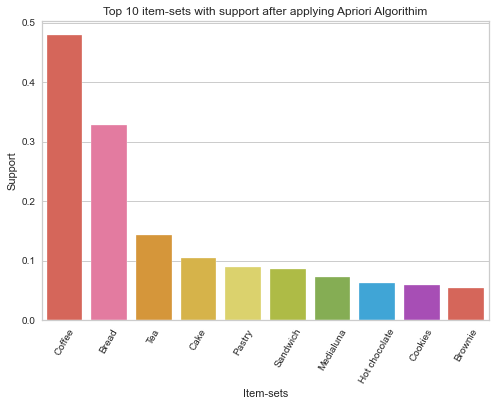

<IPython.core.display.Javascript object>

In [53]:
sns.barplot(
    frequent_itemsets["itemsets"][0:10],
    frequent_itemsets["support"][0:10],
    palette=[
        "#ea5545",
        "#f46a9b",
        "#ef9b20",
        "#edbf33",
        "#ede15b",
        "#bdcf32",
        "#87bc45",
        "#27aeef",
        "#b33dc6",
    ],
)
plt.title("Top 10 item-sets with support after applying Apriori Algorithim")
plt.xlabel("Item-sets")
plt.ylabel("Support")
plt.xticks(
    list(
        range(0, 10),
    ),
    items[0:10],
    rotation=60,
)

* The item-set in all the transactions with high support of more than 0.4 is Coffee which means it has been bought more than 40% among the other items.
* The item-set in all the transaction with low support of 0.05 approx. is Brownie which means it has been bought about 5% among the other items.

In [54]:
## Creating Rules

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905
1,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
2,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740
3,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
4,(Coffee),(Sandwich),0.478394,0.071844,0.038246,0.079947,1.112792,0.003877,1.008807
5,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384
6,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
7,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
8,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553
9,(Coffee),(Hot chocolate),0.478394,0.058320,0.029583,0.061837,1.060311,0.001683,1.003749


<IPython.core.display.Javascript object>

In [55]:
rules = rules.sort_values("lift", ascending=False).reset_index(drop=True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Tea, Coffee)",(Cake),0.049868,0.103856,0.010037,0.201271,1.937977,0.004858,1.121962
1,(Cake),"(Tea, Coffee)",0.103856,0.049868,0.010037,0.096643,1.937977,0.004858,1.051779
2,(Cake),(Hot chocolate),0.103856,0.058320,0.011410,0.109868,1.883874,0.005354,1.057910
3,(Hot chocolate),(Cake),0.058320,0.103856,0.011410,0.195652,1.883874,0.005354,1.114125
4,(Soup),(Tea),0.034443,0.142631,0.009086,0.263804,1.849557,0.004174,1.164593
5,(Tea),(Soup),0.142631,0.034443,0.009086,0.063704,1.849557,0.004174,1.031252
6,(Pastry),(Medialuna),0.086107,0.061807,0.009192,0.106748,1.727135,0.003870,1.050313
7,(Medialuna),(Pastry),0.061807,0.086107,0.009192,0.148718,1.727135,0.003870,1.073549
8,(Scone),(Tea),0.034548,0.142631,0.008347,0.241590,1.693816,0.003419,1.130483
9,(Tea),(Scone),0.142631,0.034548,0.008347,0.058519,1.693816,0.003419,1.025460


<IPython.core.display.Javascript object>

**Observations:**

* Since the minimum threshold is 1, therfore any items associated with lift values greater than 1 is showing strong relation between the antecedents and consequents.

* The customers who purchased Tea, and Coffee together are expected to buy Cake with a likelihood of 20% approximately (confidence).

* The customers who purchased Cake are expected to buy Tea, and Coffee with a likelihood of 9% approximately (confidence).

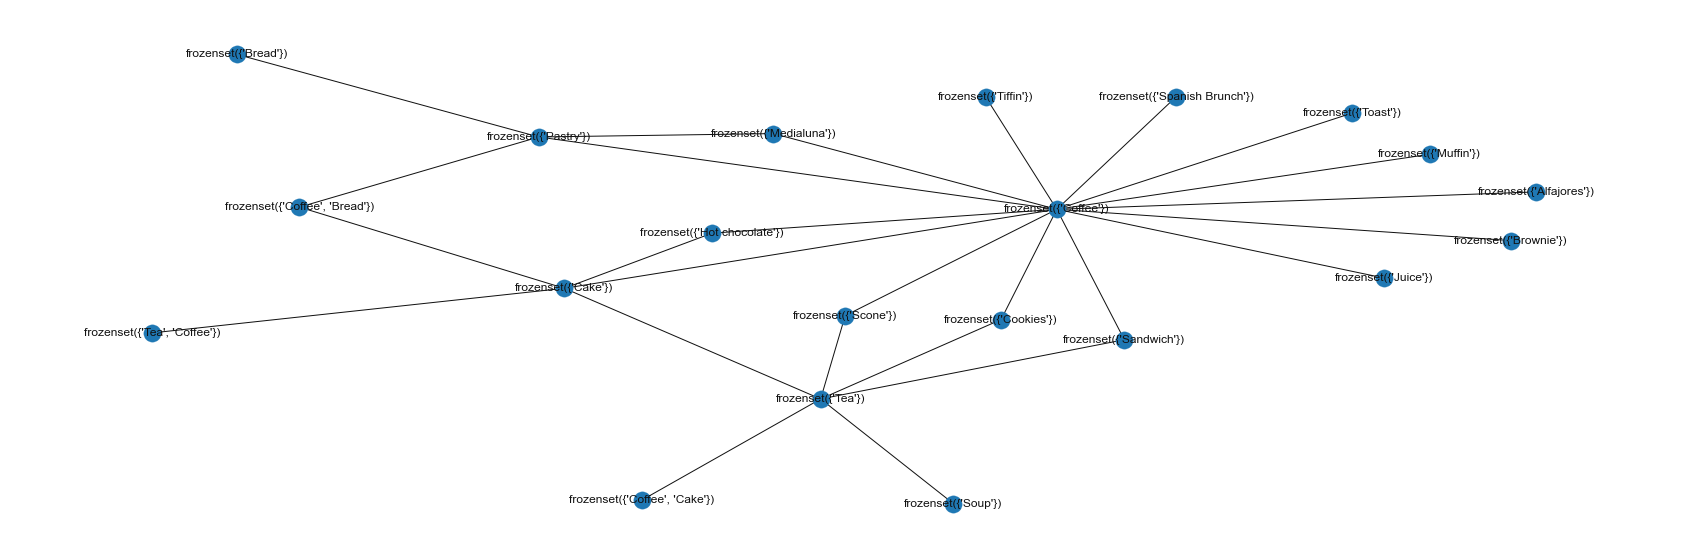

<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots(figsize=(30, 10))
graph = nx.from_pandas_edgelist(rules, source="antecedents", target="consequents")
nx.draw(graph, with_labels=True)
plt.show()

### Recommendations:

* These recommendations are based on the afternoon purchasing cycle.

* The higher lift values indcates the importance of the products which will give more revenues.

* Therefore, putting the Cakes next to the Tea, and Coffee aisle will make the customers who have already bought Tea, and Coffee more likely to buy Cakes with a cofidence of 20% approximately.

* Coffee is the bestseller of this bakery and it shows association with 4 items- pastry, cake, medialuna and sandwich. There are a couple of strategies that the bakery can adopt (if it isn't using them yet) to increase its sales by considering the association we have seen between coffee and its 4 partners.

* Promotional discount in either one of the 4 partners can attract customers to buy coffee (or the other way round, will also work).

* Placing these 4 items close to coffee ordering counter can be a good strategy to attract customers in buying these (which we see quite often to happen in many bakeries and coffee shops).

* Adding new type of cakes like coffee cake or coffee pastry, will attract coffe and cake/pastry lovers.